In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torchvision.transforms.functional as TF
from PIL import Image
import pandas as pd
import os
import multiprocessing

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from PIL import Image
import pandas as pd
import os
import torch.nn.functional as F
import multiprocessing
import joblib
from joblib import load
import torchvision.models as models
import csv

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(Generator, self).__init__()

        # Define the generator model using nn.Sequential
        self.model = nn.Sequential(
            # Initial convolution block
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=2, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            
            # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(),
            
            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            
            # Upsampling
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, output_nc, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

device = torch.device('mps')

# path to save checkpoint CHANGE EPOCH NOT WHOLE PATH
epoch = 10
checkpoint_path = f'/Users/kieran/Documents/mlpProject/0318sinkhornGAN_kieran_original_arch/epoch_{epoch}.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

input_nc = 3  # Number of input channels
output_nc = 3  # Number of output channels
# Initialize networks
G_AB = Generator(input_nc, output_nc).to(device)
G_BA = Generator(output_nc, input_nc).to(device)

# Load the state dictionaries
G_AB.load_state_dict(checkpoint['G_AB_state_dict'])
G_BA.load_state_dict(checkpoint['G_BA_state_dict'])

# Ensure the models are in evaluation mode
G_AB.eval()
G_BA.eval()

# Prepare your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_A = ImageFolder(root='/Users/kieran/Documents/mlpProject/bigCats/train/TIGER', transform=transform)
dataset_B = ImageFolder(root='/Users/kieran/Documents/mlpProject/bigCats/train/PUMA', transform=transform)

dataloader_A = DataLoader(dataset_A, batch_size=1, shuffle=True)
dataloader_B = DataLoader(dataset_B, batch_size=1, shuffle=True)

# Generate and save/display images
output_dir = f'/Users/kieran/Documents/mlpProject/0318sinkhornGAN_kieran_original_arch/generated_images_epoch_{epoch}'
os.makedirs(output_dir, exist_ok=True)


with torch.no_grad():
    for i, (real_A, _) in enumerate(dataloader_A):
        real_A = real_A.to(device)
        fake_B = G_AB(real_A)
        save_image(fake_B, os.path.join(output_dir, f'fake_B_{i}.png'))
        if i == 9:  # Save/display 10 images for demonstration
            break

    for i, (real_B, _) in enumerate(dataloader_B):
        real_B = real_B.to(device)
        fake_A = G_BA(real_B)
        save_image(fake_A, os.path.join(output_dir, f'fake_A_{i}.png'))
        if i == 9:
            break

print("Generated images have been saved to", output_dir)


Generated images have been saved to /Users/kieran/Documents/mlpProject/0318sinkhornGAN_kieran_original_arch/generated_images


In [ ]:
# Function to compute Fréchet Inception Distance (FID)
def calculate_fid(real_images, generated_images, device='mps'):
    real_images = real_images.detach().cpu().numpy()
    generated_images = generated_images.detach().cpu().numpy()

    # Preprocess images
    real_images = np.transpose(real_images, (0, 2, 3, 1))  # Change from NCHW to NHWC
    generated_images = np.transpose(generated_images, (0, 2, 3, 1))

    # Load pre-trained Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    # Compute activations for real and generated images
    with torch.no_grad():
        real_activations = inception_model(torch.tensor(real_images).to(device)).detach().cpu().numpy()
        generated_activations = inception_model(torch.tensor(generated_images).to(device)).detach().cpu().numpy()

    # Compute mean and covariance of activations
    mu_real = np.mean(real_activations, axis=0)
    mu_generated = np.mean(generated_activations, axis=0)
    cov_real = np.cov(real_activations, rowvar=False)
    cov_generated = np.cov(generated_activations, rowvar=False)

    # Compute FID
    fid = np.sum((mu_real - mu_generated) ** 2) + np.trace(cov_real + cov_generated - 2 * sqrtm(np.dot(cov_real, cov_generated)))
    return fid

In [ ]:
with torch.no_grad():
    # Ensure images are moved to CPU and converted for metric calculation
    # right now we are only working with single images
    real_image_np = real_A.cpu().numpy().transpose(0, 2, 3, 1)
    fake_image_np = fake_B.cpu().numpy().transpose(0, 2, 3, 1) 
    real_image_np = np.squeeze(real_image_np, axis = 0) # get rid of first channel because it is just batch size 1
    fake_image_np = np.squeeze(fake_image_np, axis = 0)
                # Clipping pixel values to ensure they are within [0, 1]
    print("Real image: ", real_image_np)
    print("Fake image: ", fake_image_np)
    real_image_np = np.clip(real_image_np, 0, 1)
    fake_image_np = np.clip(fake_image_np, 0, 1)

    print(real_image_np.shape, fake_image_np.shape)
    # print("Real image: ", real_image_np)
    # print("Fake image: ", fake_image_np)

    image_ssim = ssim(real_image_np, fake_image_np, multichannel=True, channel_axis = 2, dtype = np.float32, data_range =[0,1])
    image_psnr = psnr(real_image_np, fake_image_np)

    # Append scores
    ssim_scores.append(image_ssim)
    psnr_scores.append(image_psnr)

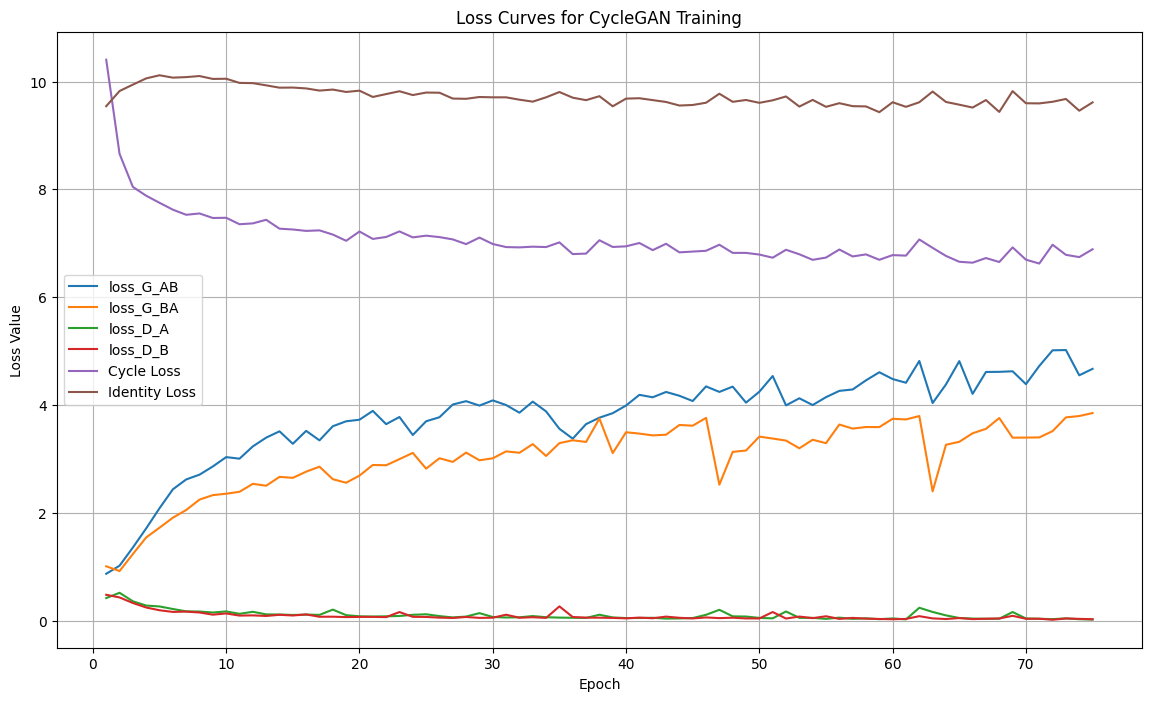

In [3]:
# graphing csv files
import pandas as pd
import matplotlib.pyplot as plt

run_name = '0315_sinkhorn_128'

# Replace 'your_data.csv' with the path to your CSV file
csv_file_path = f'/Users/kieran/Documents/mlpProject/{run_name}/training_metrics.csv'

# Load the CSV data into a DataFrame
data = pd.read_csv(csv_file_path)

# Set the 'epoch' column as the index of the DataFrame
data.set_index('epoch', inplace=True)
data = data.head(75)

# Plotting all metrics over epochs
plt.figure(figsize=(14, 8))  # Set the figure size for better readability

# Loop through all columns except for the epoch to plot each metric
for column in data.columns:
    if column in ['loss_G_AB', 'loss_G_BA', 'loss_D_A', 'loss_D_B', 'Cycle Loss', 'Identity Loss']:
        plt.plot(data.index, data[column], label=column)

plt.title('Loss Curves for CycleGAN Training')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.savefig(f'/Users/kieran/Documents/mlpProject/{run_name}/training_metrics_50epochs.png')
plt.show()